# Modeling and Simulation in Python

Chapter 17

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time')

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


Here's what the glucose time series looks like.

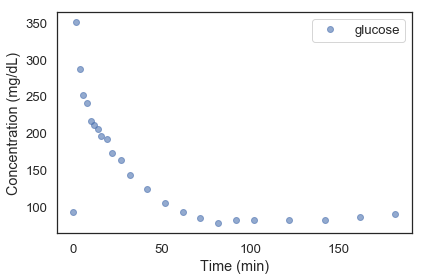

In [3]:
plot(data.glucose, 'bo', label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

And the insulin time series.

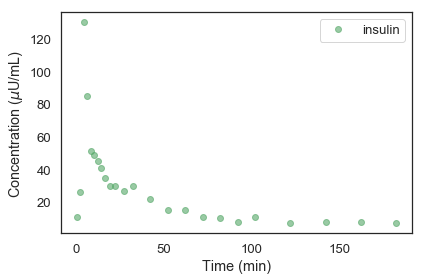

In [4]:
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

For the book, I put them in a single figure, using `subplot`

Saving figure to file figs/chap08-fig01.pdf


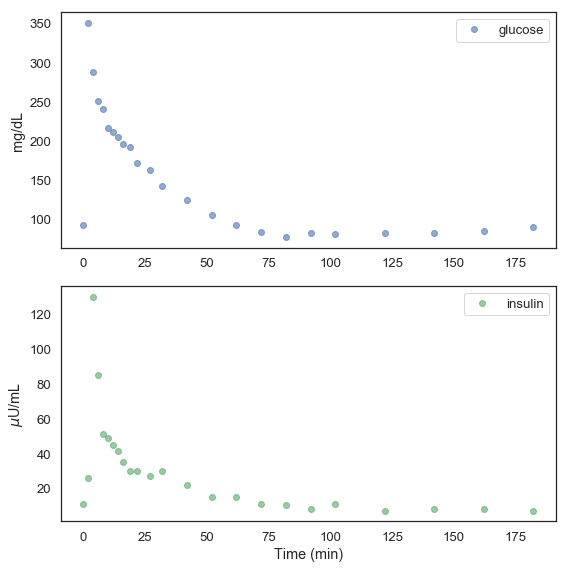

In [5]:
subplot(2, 1, 1)
plot(data.glucose, 'bo', label='glucose')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='$\mu$U/mL')

savefig('figs/chap08-fig01.pdf')

### Interpolation

We have measurements of insulin concentration at discrete points in time, but we need to estimate it at intervening points.  We'll use `interpolate`, which takes a `Series` and returns a function:

The return value from `interpolate` is a function.

In [6]:
I = interpolate(data.insulin)

We can use the result, `I`, to estimate the insulin level at any point in time.

In [7]:
I(7)

array(68.)

`I` can also take an array of time and return an array of estimates:

In [8]:
t_0 = get_first_label(data)
t_end = get_last_label(data)
ts = linrange(t_0, t_end, endpoint=True)
I(ts)
type(ts)

numpy.ndarray

Here's what the interpolated values look like.

Saving figure to file figs/chap08-fig02.pdf


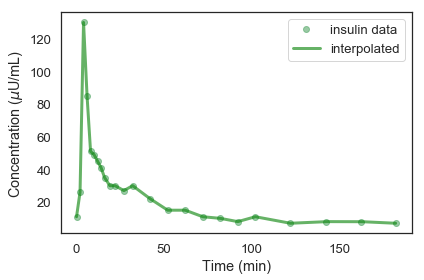

In [9]:
plot(data.insulin, 'go', label='insulin data')
plot(ts, I(ts), color='green', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

savefig('figs/chap08-fig02.pdf')

**Exercise:** [Read the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) of `scipy.interpolate.interp1d`.  Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like. 

In [10]:
import matplotlib.pyplot as plt
from scipy import interpolate

In [11]:
scipy.interpolate.interp1d(data.insulin, ts, assume_sorted=True)

ValueError: x and y arrays must be equal in length along interpolation axis.

### The glucose minimal model

I'll cheat by starting with parameters that fit the data roughly; then we'll see how to improve them.

In [ ]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

Here's a version of `make_system` that takes the parameters and data:

In [ ]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib,
                  t_0=t_0, t_end=t_end, dt=2)

In [ ]:
system = make_system(params, data)

And here's the update function.  It uses `unpack` to make the system variables accessible without using dot notation, which makes the translation of the differential equations more readable and less error prone.

In [ ]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

Before running the simulation, it is always a good idea to test the update function using the initial conditions.  In this case we can veryify that the results are at least qualitatively correct.

In [ ]:
update_func(system.init, system.t_0, system)

Now `run_simulation` is pretty much the same as it always is.

In [ ]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how we run it.  `%time` is a Jupyter magic command that runs the function and reports its run time.

In [ ]:
%time results = run_simulation(system, update_func);

The results are in a `TimeFrame object` with one column per state variable.

In [ ]:
results

The following plot shows the results of the simulation along with the actual glucose data.

In [ ]:
subplot(2, 1, 1)

plot(results.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)

plot(results.X, 'g-', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Arbitrary units')

savefig('figs/chap08-fig03.pdf')

### Under the hood

In [ ]:
%psource interpolate

### Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

In [ ]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

In [ ]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib,
                  t_0=t_0, t_end=t_end, dt=1)

In [ ]:
system = make_system(params, data)

In [ ]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [ ]:
update_func(system.init, system.t_0, system)

In [ ]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [ ]:
%time results = run_simulation(system, update_func);

In [ ]:
results

In [ ]:
subplot(2, 1, 1)

plot(results.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)

plot(results.X, 'g-', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Arbitrary units')

savefig('figs/chap08-fig03.pdf')